>Authors:
>
> - Zofia Agata Lenarczyk s242916
> - Antoine Paul Louis Aubry s243253
> - Dimitrios Tsiliakidis s243204

This notebook contains the assignment 2 for the course Social Graphs and Interactions 2025.

The content of this notebook focuses on the analysis of the rock music network. It explores the rock music network through backbone and community detection, TF-IDF analysis of Wikipedia texts, and sentiment analysis to understand genre and community structure.

In [7]:
# imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
import json
from collections import defaultdict, Counter


In the following parts of the notebook, we will refer to the rock music network created in the Assignment 1 and the *bands* folder containing the Wikipedia texts for all  artists.

In [ ]:
url_graph = "https://raw.githubusercontent.com/Azri-oss/Social_Graphs_Assignment_1/main/Assignment_1/Rock_Music_Network.graphml"

r = requests.get(url_graph)
with open("Rock_Music_Network.graphml", "wb") as f:
    f.write(r.content)

graph = nx.read_graphml("Rock_Music_Network.graphml")

In [17]:
url_bands = "https://api.github.com/repos/Azri-oss/Social_Graphs_Assignment_1/contents/Assignment_2/bands"

response_bands = requests.get(url_bands)
files_bands = response_bands.json()

# Part 1: Analyze the network

>* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   >- It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   >- I would like you to include concepts like centrality and assortativity in your analysis.
   >- Use a network backbone in your analysis.
   >- In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   >- **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network. 

# Part 2: Genres and communities and plotting 


>* Write about genres and modularity.
>* Detect the communities, discuss the value of modularity in comparison to the genres.
>* Calculate the matrix $D$ and discuss your findings.
>* Plot the communities and comment on your results.


### **Question 2.1 :** Write about genres and modularity

In this question, we first aim to gather the genres of each artist into a single dictionary. This will allow us to analyze the network through the lens of rock artists genres.

In [9]:
# Because some of the wikipedia pages have different names for a same genre, we need to do a normalization.

GENRE_NORMALIZATION = {
    "rock'n'roll": "rock and roll",
    "rock & roll": "rock and roll",
    "rock&roll": "rock and roll",
    "hip-hop": "hip hop",
    "r&b": "rhythm and blues",
    "rhythm & blues": "rhythm and blues",
    "rnb": "rhythm and blues",
    "r b": "rhythm and blues",
}
def normalize_genre_mapping(genre):
    g = genre.lower().strip()
    g = g.replace("'", "").replace('"', "")
    g = re.sub(r'\s+', ' ', g)
    return GENRE_NORMALIZATION.get(g, g)



In [ ]:
# Regex was done using LLM
def extract_genres_from_wikitext_simple(wikitext):
    """
    Only extract genres from [[...]] just after | genre = ...
    Stop capturing as soon as another field starts (|).
    """
    if not wikitext:
        return []

    genres_found = []

    # delete HTML comments
    text = re.sub(r'<!--.*?-->', '', wikitext, flags=re.DOTALL)
    # only get information after genre= and before "|"
    match = re.search(r'\|\s*genre\s*=\s*((?:.|\n)*?)(?=\n\s*\||<ref>|$|\Z)', text, re.IGNORECASE)
    if not match:
        return []

    block = match.group(1)

    # extract content inside [[...]]
    links = re.findall(r'\[\[([^\]]+)\]\]', block) 
    for link in links:
        # part after "|" if it exists
        genre = link.split('|')[-1].strip().lower()
        # remove parentheses and content inside
        genre = re.sub(r'\(.*?\)', '', genre) 
        # to keep special characters like ä, letters and figures.
        genre = re.sub(r'[^(\w)\s&/-]', ' ', genre) 
        # normalize spaces
        genre = re.sub(r'\s+', ' ', genre).strip() 
        if genre:
            genres_found.append(genre)

    return genres_found



In [ ]:
def genre_mapping(files_bands):
    dict = {}
    for file_info in files_bands:
        # load file content from GitHub API
        url = file_info['download_url']
        response = requests.get(url)
        data = response.json()
        # get artist name and wikitext from JSON file
        artist = data.get('page','')
        wikitext = data.get('wikitext','')
        genres = extract_genres_from_wikitext_simple(wikitext)
        normalized_genres = [normalize_genre_mapping(g) for g in genres]
        dict[artist] = normalized_genres
    return dict

dict_mapping = genre_mapping(files_bands)

Processing artist: 38_Special_(band)
Processing artist: 10_Years_(band)
Processing artist: 10cc
Processing artist: 311_(band)
Processing artist: 3_Doors_Down
Processing artist: ABBA
Processing artist: AC/DC
Processing artist: AFI_(band)
Processing artist: A_Perfect_Circle
Processing artist: Accept_(band)
Processing artist: Adam_Ant
Processing artist: Aerosmith
Processing artist: Air_Supply
Processing artist: Alanis_Morissette
Processing artist: Alice_Cooper
Processing artist: Alice_Cooper_(band)
Processing artist: Alice_in_Chains
Processing artist: Alter_Bridge
Processing artist: Ambrosia_(band)
Processing artist: America_(band)
Processing artist: Anthrax_(American_band)
Processing artist: April_Wine
Processing artist: Arcade_Fire
Processing artist: Arctic_Monkeys
Processing artist: Asia_(band)
Processing artist: Audioslave
Processing artist: Avenged_Sevenfold
Processing artist: Avril_Lavigne
Processing artist: Awolnation
Processing artist: Bachman–Turner_Overdrive
Processing artist: B

**Modularity :** The modularity represents the ability of a graph to have distinct and strong communities. Indeed, by taking into account inter-community and extra community edges, this measure indicates if the graph can be divided into communities and clusters. The following formula gives the modularity of a graph :

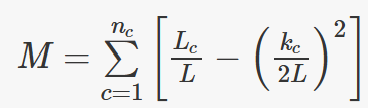

With 
* n<sub>c</sub>: number of communities
* L<sub>c</sub>: number of edges within the community C
* k<sub>c</sub>: total degree of the nodes in the community C
* L: number of edges in the graph

In [ ]:
G_undirected = graph.to_undirected()


# Part 3: TF-IDF to understand genres and communities 


>* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
>* Calculate and visualize TF-IDF for the genres and communities.
>* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.


# Part 4: Sentiment of the artists and communities


>* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
>* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?